# Fractal in Biology (West 1997)

This notebook checks the result in [West, et al. (1997)](https://www.science.org/doi/10.1126/science.276.5309.122). This paper concludes that fractal in biology results in the minimization of total energy cost. In the specific case considered by the authors, the mammalian circulatory systems, the fractal branching of capillary vessel naturally arises from reducing the energy cost of vessel circulation. Here, we check this result by numerical optimization method.

## Notations

We follow the notations:

- $C$: number of branching levels.
- $k$: branching level, from $0$ to $C$.
- $n_k$: number of branches at $k$ level.
- $r_k$: radius of vessel at $k$ level.
- $l_k$: length of vessel at $k$ level.
- $\nu_k$: $n_{k+1} / n_k$.
- $\rho_k$: $r_{k+1} / r_k$.
- $\lambda_k$: $l_{k+1} / l_k$.

## Assumptions

The assumption that the properties of capillary are universal for all mammals implies that the $n_C$, $l_C$, and $r_C$ are fixed. So, we have

$$ l_k = \frac{l_k}{l_{k+1}} \cdots \frac{l_{C-1}}{l_C} l_C = l_C \lambda_k^{-1} \cdots \lambda_{C-1}^{-1} = l_C \prod_{i=k}^{C-1} \lambda_i^{-1}. $$

The same,

$$ r_k = r_C \prod_{i=k}^{C-1} \rho_i^{-1}, $$

  and

$$ n_k = n_C \prod_{i=k}^{C-1} \nu_i^{-1}. $$

Based on assumption of area-preserving, we have that $n_k r_k^2$ is independent of $k$. This implies

$$ \rho_k = \nu_k^{-1/2}. $$

And by assumption of space-fulfilling, we have that $n_k l_k^3$ is independent of $k$. This implies

$$ \lambda_k = \nu_k^{-1/3}. $$

Because of these, the unique degree of freedom is the $\nu$.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tqdm import tqdm
import matplotlib.pyplot as plt

2024-03-04 21:00:05.045857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We use several samples in searching optimal parallelly. So, the $\nu$, or for numerical stability $\ln \nu$, has tensor shape `[samples, levels]`.

In [2]:
SAMPLES = 10
LEVELS = 20

## Loss Function

The quantity to be minimized is the total resistance of the vessel system. By [Hagen-Poiseuille equation](https://en.wikipedia.org/wiki/Hagen%E2%80%93Poiseuille_equation#Equation), we have the difference of pressure at level $k$, $\Delta p_k = Q_k R_k$ where $Q_k$ represents the flow rate and $R_k := (8 \mu l_k)/(\pi r_k^4)$. Analogy to electricity, $\Delta p_k$ corresponds to difference of potential $\Delta V$, and $Q_k$ to current $I$. So, the $R_k$ is the resistance. At level $k$, the vessels are parallel. And for different levels, vessels are serial. So, the total resistance comes to be

$$ R_b = \sum_{k=0}^{C} \frac{R_k}{n_k} = \frac{8\mu}{\pi} \sum_{k=0}^{C} \frac{l_k}{r_k^4 n_k} = \frac{8\mu}{\pi} \frac{l_C}{r_C^4 n_C} \sum_{k=0}^{C} \prod_{i=k}^{C-1} \frac{\rho_i^4 \nu_i}{\lambda_i}. $$

Plugging into the relation between $\rho$, $\lambda$ and $\nu$, we find

$$ R_b = \frac{8\mu}{\pi} \frac{l_C}{r_C^4 n_C} \sum_{k=0}^{C} \prod_{i=k}^{C-1} \nu_i^{-2/3}. $$

For numerical stability, we consider

$$ \ln R_b = \ln \left( \frac{8\mu}{\pi} \frac{l_C}{r_C^4 n_C} \right) + \ln \sum_{k=0}^{C} \prod_{i=k}^{C-1} \nu_i^{-2/3}. $$

In [3]:
def get_log_resistance(log_nu):
    """Omit the constant."""
    logits = []
    for k in range(LEVELS+1):
        logits.append(-(2/3) * tf.reduce_sum(log_nu[:, k:], axis=1))
    logits = tf.stack(logits, axis=1)
    return tf.reduce_logsumexp(logits, axis=1)

log_nu = np.log(2) * np.ones([1, LEVELS])
get_log_resistance(log_nu)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.99408455])>

It is also assumed that the blood volume is proportional to the body size. The blood volumne is given by

$$ V_b = \pi \sum_{k=0}^C r_k^2 l_k n_k = \pi r_C^2 l_C n_C \sum_{k=0}^C \prod_{i=k}^{C-1} \frac{1}{\rho_i^2 \lambda_i \nu_i} = \pi r_C^2 l_C n_C \sum_{k=0}^C \prod_{i=k}^{C-1} \nu_i^{1/3}. $$

If the body size is fixed, then $V_b$ shall be fixed too. Then,

$$ \ln V_b = \ln \left( \pi r_C^2 l_C n_C \right) + \ln \sum_{k=0}^C \prod_{i=k}^{C-1} \nu_i^{1/3}. $$

In [4]:
def get_log_volume(log_nu):
    """Omit the constant."""
    logits = []
    for k in range(LEVELS+1):
        logits.append((1/3) * tf.reduce_sum(log_nu[:, k:], axis=1))
    logits = tf.stack(logits, axis=1)
    return tf.reduce_logsumexp(logits, axis=1)

get_log_volume(log_nu)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([6.19156443])>

Since $n_{k+1} \ge n_k$, $\nu_k$ shall be greater than unit. So, there is another constraint that, for each $k$,

$$ \ln \nu_k \ge 0. $$

Altogether, the loss function shall be

$$ \ln R_b(\nu) + \mu \left( \ln V_b(\nu) - \ln \bar{V}_b \right) + \sum_{k=1}^{C-1} \omega_k \left( \ln \nu_k - z_k^2 \right), $$

for some observed values $\bar{V}_b$ given.

What is a proper value of $\bar{V}_b$. It is natural to suppose that $n_{k+1}/n_k \ge 2$. This means $\bar{V}_b$ shall be greater than the volume given by $\nu = 2$. And it shall not be too large, for numerical consideration.

In fact, it is sufficient for the optimized volume to approximate the order of $\bar{V}_b$. We can regard this optimized volume as the real $\bar{V}_b$. In other words, $\bar{V}_b$ is used to determine the order, but not the accurate value.

In [5]:
least_log_volume = get_log_volume(np.log(2) * np.ones([1, LEVELS]))
least_log_volume

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([6.19156443])>

In [6]:
TRUE_LOG_VOLUME = 3e+1

In [7]:
def get_loss(log_nu, z, mu, omega):
    objective = get_log_resistance(log_nu)
    loss = tf.reduce_sum(objective)
    constraints = []
    for multiplier, constraint in [
        (mu, get_log_volume(log_nu) - TRUE_LOG_VOLUME),
        (omega, log_nu - tf.square(z)),
        # other constraints......
    ]:
        loss += tf.reduce_sum(multiplier * constraint)
        constraints.append(constraint)
    return objective, constraints, loss

z = tf.ones_like(log_nu)
get_loss(log_nu, z, 0.1, 0.1)

(<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.99408455])>,
 [<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-23.80843557])>,
  <tf.Tensor: shape=(1, 20), dtype=float64, numpy=
  array([[-0.30685282, -0.30685282, -0.30685282, -0.30685282, -0.30685282,
          -0.30685282, -0.30685282, -0.30685282, -0.30685282, -0.30685282,
          -0.30685282, -0.30685282, -0.30685282, -0.30685282, -0.30685282,
          -0.30685282, -0.30685282, -0.30685282, -0.30685282, -0.30685282]])>],
 <tf.Tensor: shape=(), dtype=float64, numpy=-2.0004646427167665>)

## Gradient Descent with Constraints

The gradient descent algorithm with constraints is described in [Platt and Barr (1988)](https://papers.nips.cc/paper_files/paper/1987/file/a87ff679a2f3e71d9181a67b7542122c-Paper.pdf). Briefly, descent on the parameters (the $\ln \nu$ here) and ascent on the multipliers (the $\mu$ and $\omega_k$ here). For numerical stability, it is suggested to add an $L_2$-regulation.

For example, consider scalar functions $f$ and $g$ where $f$ is lower bounded. If you want to minimize $f(x)$ with constraint $g(x) = 0$, then the loss function will be

$$ L(x, \mu) = f(x) + \mu g(x), $$

where $\mu$ is the Lagrangian multiplier. Then, optimize the $x$ along the direction

$$ \dot{x}^a = -\nabla^a L(x, \mu) = -\nabla^a f(x) - \mu \nabla^a g(x), $$

where the $\nabla$ is taken on $x$ only. And optimize the $\mu$ along the direction

$$ \dot{\mu} = {\color{red}+} \partial_{\mu} L(x, \mu) = g(x). $$

Indeed, by taking time derivative, we find

$$ \ddot{x}^a + \left( \nabla^a \nabla_b f(x) + \mu \nabla^a \nabla_b g(x) \right) \dot{x}^b + \nabla^a \left( \frac{1}{2} g^2(x) \right) = 0. $$

Analogy to the damped mechanic system, we recognize that the $A^a_b(x) := \nabla^a \nabla_b f(x) + \mu \nabla^a \nabla_b g(x)$ term is a friction coefficient and $g^2(x)$ a potential. So, the energy is $E(x) := (1/2) \dot{x}^2 + (1/2) g^2(x)$, and because of friction, the energy loss rate is $\dot{E}(x) = -A_{a b}(x) \dot{x}^a \dot{x}^b$. So, to ensure that the energy losses, $A(x)$ has to be positive definite, at least being positive definite near the minimum. This is true for $\nabla^a \nabla_b f(x)$ since $f$ is lower bounded. So, we have to restrict the scale of $g$ such that $A$ is positive definite. To do so, we add an $L_2$-regulation for $g(x)$, that is, a term $c g^2(x)$ for a large enough positive constant $c$.

For inequal constraints, like $h(x) \ge 0$, we can add an auxiliary parameter $z$ and set the $g$ as $h(x) - z^2$. In this way, when $g = 0$, $h(x) \ge 0$ is fulfilled. Now, the loss function becomes $L(x, z, \mu) = f(x) + \mu \left( h(x) - z^2 \right)$. The $z$ is optimized in the same way as $x$, that is $\dot{z} = -\nabla_z L(x, z, \mu) = 2 \mu z$. Remark that when $z = 0$, $\dot{z} = 0$ too. Thus $z$ will not be updated and keeps vanishing. This is not what we want. So, at least, $z$ shall not be initialized as $0$ in training.

In [8]:
def get_train_step(optimizer, l2):
    step = tf.Variable(0, dtype=tf.int32, trainable=False)
    l2 = tf.convert_to_tensor(l2)

    @tf.function
    def train_step(log_nu, z, mu, omega):
        with tf.GradientTape() as tape:
            objective, constraints, loss = get_loss(log_nu, z, mu, omega)
            loss += l2 * sum(tf.reduce_sum(tf.square(c)) for c in constraints)

        # Compute gradients
        vars = [log_nu, z, mu, omega]
        grads = tape.gradient(loss, vars, unconnected_gradients='zero')

        # Descent for parameters and ascent for multipliers:
        grads_and_vars = []
        for i, var in enumerate(vars):
            if i < 2:
                grads_and_vars.append((grads[i], vars[i]))
            else:
                grads_and_vars.append((-grads[i], vars[i]))

        optimizer.apply_gradients(grads_and_vars)
        check_nan(vars)
        step.assign_add(1)
        return objective, constraints, loss, grads_and_vars

    return train_step, step

def check_nan(xs):
    for x in xs:
        try:
            tf.debugging.check_numerics(x, message='')
        except Exception as e:
            raise ValueError('NaN value.')

## Training

Initialize the parameters and Lagrangian multipliers:

In [9]:
log_nu = tf.Variable(tf.random.uniform([SAMPLES, LEVELS], np.log(2), np.log(6)))
z = tf.Variable(tf.random.uniform([SAMPLES, LEVELS], 0.5, 1.))  # z shall not be zero.
mu = tf.Variable(tf.zeros([SAMPLES, 1]))
omega = tf.Variable(tf.zeros([SAMPLES, LEVELS]))
optimizer = keras.optimizers.adam_v2.Adam()
train_step, step = get_train_step(optimizer, 1e-1)
objective_logs = []
loss_logs = []

Let us log the objective and constraints before training.

In [10]:
objective, constraints, _, _ = train_step(log_nu, z, mu, omega)
objective, constraints

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.5015508 , 0.65446323, 0.48367184, 0.5643646 , 0.5231243 ,
        0.52457994, 0.48574182, 0.41622874, 0.40424636, 0.6362983 ],
       dtype=float32)>,
 [<tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([-20.361494, -20.990639, -20.00923 , -20.617174, -20.229631,
         -20.73936 , -21.049255, -20.306458, -20.16538 , -21.004622],
        dtype=float32)>,
  <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
  array([[ 0.35822386,  0.41031158,  1.2176999 ,  0.8435954 ,  0.66743153,
           1.4756255 ,  0.5817856 ,  0.90950555,  1.0118196 ,  0.18865216,
           0.98958313,  1.0629853 ,  0.842096  ,  0.05623168,  0.79188395,
           0.67446816,  0.5415292 ,  0.656713  ,  0.41568568,  1.2700822 ],
         [ 0.7272637 ,  0.47206017,  1.0181084 ,  0.25810218,  0.748346  ,
          -0.11299056,  1.1282136 ,  0.21328491,  0.37889385,  1.0129815 ,
           1.0413439 ,  0.7407811 ,  0.2799478 ,  0.28686053,  0.76170385,


In [11]:
for i in tqdm(range(500000)):
    objective, _, loss, _ = train_step(log_nu, z, mu, omega)
    objective_logs.append(objective.numpy().mean())
    loss_logs.append(loss.numpy())

100%|██████████████████████████████████████████████████| 500000/500000 [05:50<00:00, 1426.86it/s]


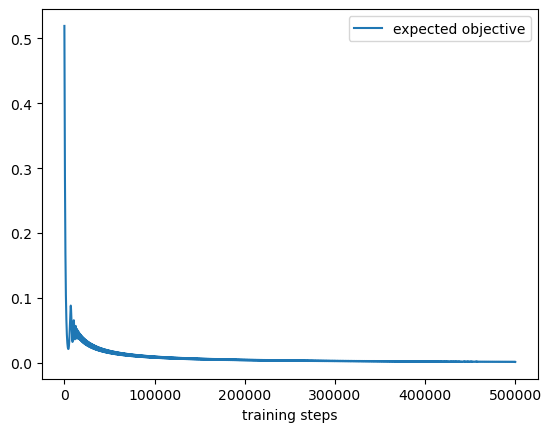

In [12]:
plt.plot(objective_logs, label='expected objective')
# plt.plot(loss_logs, label='loss', alpha=0.5)
plt.xlabel('training steps')
plt.legend()
plt.show()

Let us check the optimization results:

In [13]:
objective, constraints, _ = get_loss(log_nu, z, mu, omega)

In [14]:
min_i = tf.argmin(objective)
min_i, objective[min_i], [c[min_i] for c in constraints]

(<tf.Tensor: shape=(), dtype=int64, numpy=8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0017884464>,
 [<tf.Tensor: shape=(), dtype=float32, numpy=0.19229889>,
  <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([-0.09135246,  0.09264612, -0.1067977 , -0.08253837,  0.08851719,
          0.0799017 ,  0.01009274, -0.04937983,  0.07096386,  0.10009813,
         -0.1156292 , -0.05639076,  0.10319757, -0.04201674, -0.07538652,
          0.09879208, -0.11145496,  0.05728555,  0.07284975,  0.06654167],
        dtype=float32)>])

And for checking fractal:

In [15]:
log_nu[min_i, :]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([4.1677995, 4.861213 , 4.502962 , 3.6936588, 4.4591756, 4.5444136,
       3.5875077, 4.349291 , 3.693872 , 4.591625 , 4.140812 , 4.723901 ,
       4.022458 , 3.7121122, 3.7484918, 4.397069 , 4.5674434, 3.7025912,
       4.7357583, 9.556167 ], dtype=float32)>

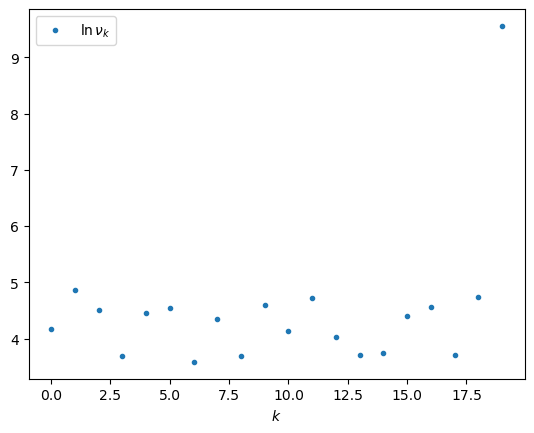

In [16]:
plt.plot(log_nu[min_i, :], '.', label='$\\ln \\nu_k$')
# plt.plot(tf.exp(log_nu[min_i, :]), '.', label='$\\nu_k$')
plt.xlabel('$k$')
plt.legend()
plt.show()

Fractal does not emerge. The reason is that the leading term in $R_b$ is not permutation symmetric on all $\nu_k$.

Now, we can see how many branches there are. Notice that

$$ \frac{n_c}{n_1} = \frac{n_C}{n_{C-1}} \cdots \frac{n_2}{n_1} = \prod_{k=1}^{C-1} \nu_k, $$

and that $n_1 = 1$, we find

$$ n_c = \prod_{k=1}^{C-1} \nu_k. $$

In [17]:
def get_log10_nc(log_nu):
    return tf.reduce_sum(log_nu, axis=1) * np.log10(np.e)

get_log10_nc(log_nu)[min_i]

<tf.Tensor: shape=(), dtype=float32, numpy=38.98154>

## Conclusion

In the paper of West, et al (1997), the fractal structure is "analytically derived". But, as we have numerically tested here, when the `TRUE_LOG_VOLUME` is not large enough, fractal structure will not appear. Instead, it will have a single branching, that is, all $\nu_k$ except for one are unit.

Even when the `TRUE_LOG_VOLUME` is large, fractal does not emerge. It is observed that $n_{C-1} \gg n_k$ for any $k < C-1$. This is because the leading term ($k = C-1$) of $R_b$ is not permutation symmetric for all $\nu_k$, but dominated by $\nu_{C-1}$. In fact, if you modify the objective by

$$ \ln \sum_{k=0}^{C} \prod_{i=k}^{C-1} \nu_i^{{\color{red}+} 2/3}, $$

where we flipped the sign (the red font), fractal will appear. In this case, the leading term ($k = 0$) is permutation symmetric for all $\nu_k$.